In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import itertools
import json
import sklearn 
import sklearn.decomposition
import sklearn.manifold
import numpy as np
import pandas as pd

class PCATSNE(sklearn.manifold.TSNE):
    
    def __init__(self, pca_kwargs, **kwargs):
        super().__init__(**kwargs)
        self.pca_kwargs = pca_kwargs
        self.pca = sklearn.decomposition.PCA(**pca_kwargs)
        
    def fit_transform(self, X):
        # First do PCA
        X = self.pca.fit_transform(X)
        # Then do tSNE on PCA transform
        X = super().fit_transform(X)
        return X
    

In [2]:
fname = '../embeddings/cifar100_davinci-001.json'
with open(fname, 'r') as f:
    embeddings = json.load(f)

In [3]:
n = 20
X = np.asarray(list(embeddings.values()))
#X = X[:5*n, :]

In [4]:
#tf = sklearn.manifold.TSNE(n_components=2, random_state=0, method='exact', n_iter=10000, learning_rate='auto', init='pca', perplexity=3.5)
#tf = sklearn.manifold.LocallyLinearEmbedding(n_neighbors=15, reg=0, random_state=0, n_components=2, max_iter=1e4, method='modified', eigen_solver='dense')
#tf = sklearn.decomposition.PCA(n_components=2)
tf = PCATSNE(pca_kwargs={'n_components': 100, 'random_state': 1}, n_components=2, random_state=0, method='exact', n_iter=20000, n_iter_without_progress=500, min_grad_norm=1e-8, learning_rate='auto', init='pca', perplexity=5)
#tf = sklearn.manifold.TSNE(n_components=2, random_state=0, method='exact', n_iter=20000, n_iter_without_progress=500, min_grad_norm=1e-8, learning_rate='auto', init='pca', perplexity=5)
transformed = tf.fit_transform(X)

/home/chrisw/miniconda3/envs/lm_labels/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [5]:
df = pd.DataFrame(transformed)

In [6]:
df = df.rename(columns={0: "x1", 1: "x2"})

In [7]:
groups = [i for ii in zip(*itertools.repeat(range(n), 5)) for i in ii ]
names = list(embeddings.keys())


Text(0, 0.5, 'x2')

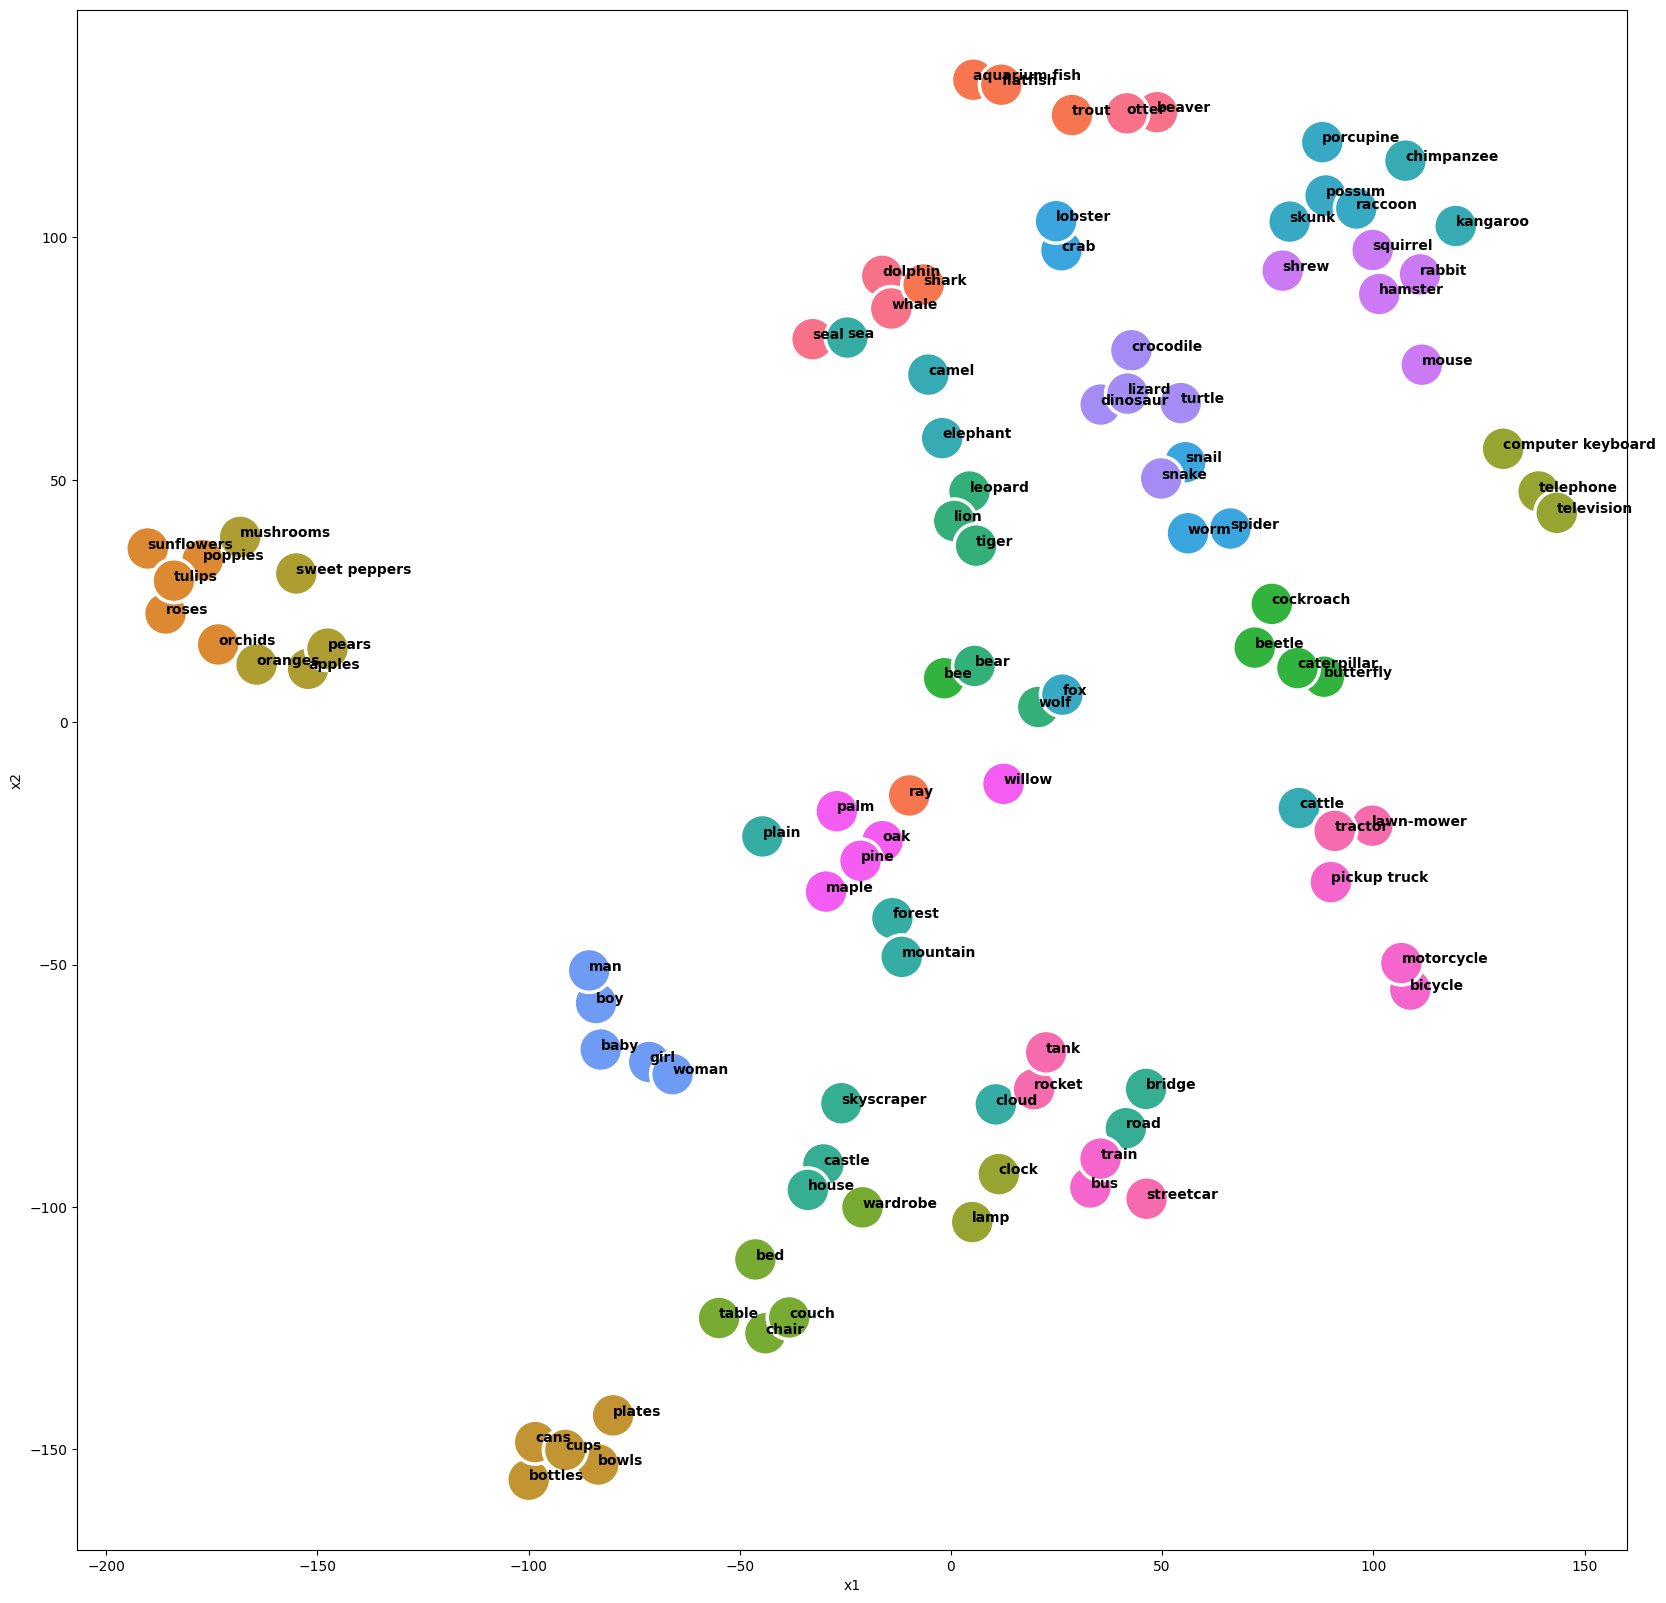

In [8]:
plt.figure(figsize=(20,20))
p1 = sns.scatterplot(x='x1', # Horizontal axis
       y='x2', # Vertical axis
       hue=groups,
       data=df, # Data source
       legend=False, 
       s=1000,
       palette=sns.color_palette("husl", n))  

for line in range(0,df.shape[0]):
     p1.text(df.x1[line], df.x2[line], 
     names[line], horizontalalignment='left', 
     size='medium', color='black', weight='semibold')

# Set x-axis label
plt.xlabel('x1')
# Set y-axis label
plt.ylabel('x2')
#plt.savefig('../results/cifar100_tsne2d.pdf')

In [9]:
df

,x1,x2
0,48.790344,125.813759
1,-16.252377,92.063622
2,41.625580,125.575348
3,-32.750832,79.001831
4,-14.131076,85.326454
...,...,...
95,99.737938,-21.339453
96,19.685200,-75.688728
97,46.310314,-98.279930
98,22.529509,-68.091736


# Crosscorrelation

In [10]:
emb = list(embeddings.values())
emb = np.asarray(emb)
print(np.linalg.norm(emb, axis=1))
emb /= np.linalg.norm(emb, axis=1)[:, np.newaxis]

[1.00000001 0.99999997 0.99999999 1.00000006 1.         1.00000006
 0.99999993 0.99999999 1.00000002 1.00000003 0.99999999 0.99999995
 1.         1.00000003 0.99999993 1.00000002 1.         1.00000003
 1.00000004 0.99999999 1.         0.99999999 1.00000003 1.00000001
 0.99999995 0.99999994 0.99999998 1.         1.         0.99999992
 0.9999999  1.00000002 1.00000001 0.99999999 0.99999999 0.99999997
 1.         1.00000005 1.00000002 0.99999998 1.00000006 0.99999997
 0.99999998 1.00000001 1.00000002 1.         0.99999997 0.99999998
 1.00000006 0.99999997 0.99999999 1.00000003 0.99999996 0.99999999
 1.00000006 0.99999997 0.99999998 0.99999997 0.99999997 1.
 1.00000002 1.00000004 1.00000002 1.00000004 1.00000005 1.00000002
 0.99999995 0.99999997 0.99999995 1.         1.00000003 1.00000001
 0.99999996 1.00000001 1.00000008 0.99999995 0.99999996 1.
 0.99999998 1.         1.00000004 0.99999996 1.00000003 1.00000002
 1.00000003 0.99999996 1.         1.00000001 0.99999997 0.99999994
 0.99999999

In [14]:
crosscorrelation = emb.dot(emb.T)
labels = list(embeddings.keys())

In [ ]:
fig, ax = plt.subplots(figsize=(25,25))  
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(crosscorrelation- np.eye(len(labels)) + np.quantile(crosscorrelation, 0.95)*np.eye(len(labels)), cmap=cmap,
            square=True, linewidths=.5, center=np.min(crosscorrelation), cbar_kws={"shrink": .5})
plt.xticks(np.arange(len(labels)), labels, rotation=60)
plt.yticks(np.arange(len(labels)), labels)
plt.savefig('cifar100.pdf')